# Импорты

In [1]:
# import os
# import warnings
# import optuna
# import time
# import shap

# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error as mae
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler 
# from sklearn.dummy import DummyRegressor
# from lightgbm.sklearn import LGBMRegressor
# from sklearn.linear_model import LinearRegression
# from catboost import CatBoostRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.model_selection import GridSearchCV, KFold

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from catboost import CatBoostRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler 

from sqlalchemy import create_engine

In [3]:
RANDOM_STATE = 190224

# Загрузка и анализ данных

## Загрузка данных

In [4]:
db_config = {
'user': 'praktikum_student',# имя пользователя
'pwd': 'Sdf4$2;d-d30pp',# пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения
'db': 'data-science-final'# название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
engine = create_engine(connection_string)
del db_config
del connection_string

In [6]:
data_arc = None
data_bulk = None
data_bulk_time = None
data_gas = None
data_temp = None
data_wire = None
data_wire_time = None

TABLES = [data_arc,
          data_bulk,
          data_bulk_time,
          data_gas,
          data_temp,
          data_wire,
          data_wire_time]

DB_TABLES = ['steel.data_arc',
             'steel.data_bulk',
             'steel.data_bulk_time',
             'steel.data_gas',
             'steel.data_temp',
             'steel.data_wire',
             'steel.data_wire_time']

for i, table in enumerate(TABLES):
    query = f'''
        SELECT *
        FROM {DB_TABLES[i]};
        '''

    TABLES[i] = pd.read_sql_query(query, engine)

data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time = TABLES


## Данные об электродах

Таблица steel.data_arc
* key — номер партии;
* BeginHeat — время начала нагрева;
* EndHeat — время окончания нагрева;
* ActivePower — значение активной мощности;
* ReactivePower — значение реактивной мощности.

In [7]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [8]:
data_arc.describe()

,key,ActivePower,ReactivePower
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [9]:
data_arc.sample(5)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
4105,881,00:27:20,00:32:55,1.487741,1.121493
8967,1944,06:26:51,06:29:33,0.729064,0.425946
9470,2054,16:14:23,16:20:40,1.401763,1.061560
11478,2506,08:04:04,08:06:02,0.407173,0.308922
5865,1276,11:07:14,11:08:00,0.149946,0.112219


In [10]:
for column in ['BeginHeat', 'EndHeat']:
    data_arc[column] = data_arc[column].fillna('00:00:00')

for column in ['BeginHeat', 'EndHeat']:
    data_arc[column] = pd.to_datetime(data_arc[column], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data_arc[column], format='%H:%M:%S').dt.minute


In [11]:
data_arc.duplicated().sum()

0

In [12]:
data_arc[data_arc['ReactivePower'] < 0]

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
9781,2116,44,46,0.495782,-715.504924


In [13]:
data_arc_analysis = data_arc.copy()
data_arc_analysis = data_arc_analysis.drop(data_arc_analysis.query('key == 2116').index).reset_index(drop=True)

In [14]:
data_arc['FullPower'] = (data_arc['ActivePower']**2 + data_arc['ReactivePower']**2)**0.5
data_arc['delta_t'] = data_arc['EndHeat'] - data_arc['BeginHeat'] 
data_arc.head()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,FullPower,delta_t
0,1,662,666,0.976059,0.687084,1.193639,4
1,1,667,670,0.805607,0.520285,0.959010,3
2,1,671,674,0.744363,0.498805,0.896038,3
3,1,678,684,1.659363,1.062669,1.970470,6
4,1,686,688,0.692755,0.414397,0.807239,2


In [15]:
data_arc = data_arc.drop(['BeginHeat', 'EndHeat'], axis=1)

In [16]:
data_arc = data_arc.groupby(by='key').mean()
data_arc.head()

,ActivePower,ReactivePower,FullPower,delta_t
key,,,,
1,0.975629,0.636648,1.165279,3.6
2,0.763150,0.499528,0.912304,3.5
3,0.505176,0.319815,0.597907,2.4
4,0.802313,0.515074,0.953741,3.0
5,0.836793,0.563161,1.008939,3.5


### Аналитика

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


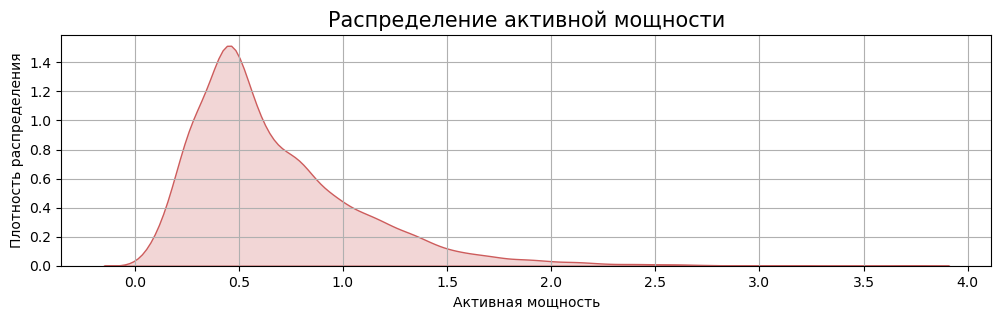

In [17]:
plt.figure(figsize=(12, 3))

sns.kdeplot(data_arc_analysis['ActivePower'], color='indianred', legend=True, fill=True)
plt.xlabel('Активная мощность')
plt.ylabel('Плотность распределения')
plt.title('Распределение активной мощности', fontsize=15)
plt.grid();

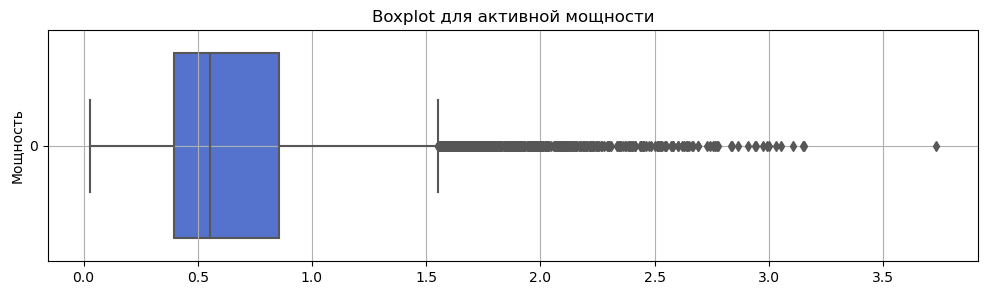

In [18]:
plt.figure(figsize=(12, 3))

sns.boxplot(data=data_arc_analysis['ActivePower'], color='royalblue', orient='h')
plt.title('Boxplot для активной мощности')
plt.ylabel('Мощность')
plt.grid();

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


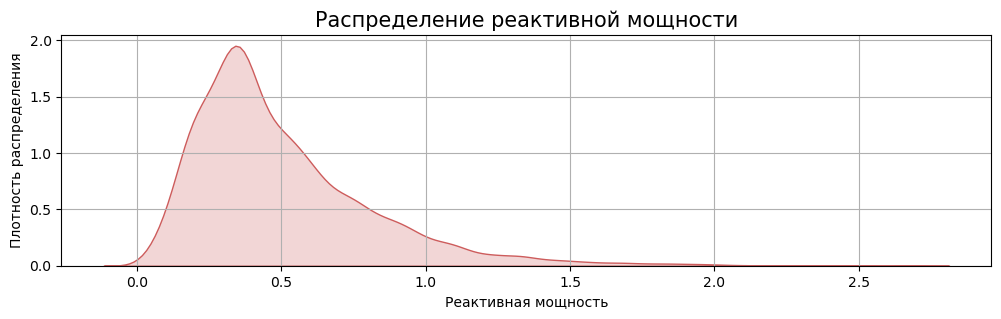

In [19]:
plt.figure(figsize=(12, 3))

sns.kdeplot(data_arc_analysis['ReactivePower'], color='indianred', legend=True, fill=True)
plt.xlabel('Реактивная мощность')
plt.ylabel('Плотность распределения')
plt.title('Распределение реактивной мощности', fontsize=15)
plt.grid();

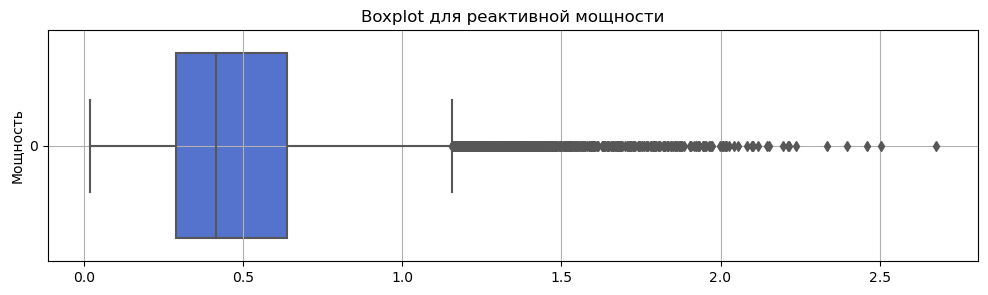

In [20]:
plt.figure(figsize=(12, 3))

sns.boxplot(data=data_arc_analysis['ReactivePower'], color='royalblue', orient='h')
plt.title('Boxplot для реактивной мощности')
plt.ylabel('Мощность')
plt.grid();

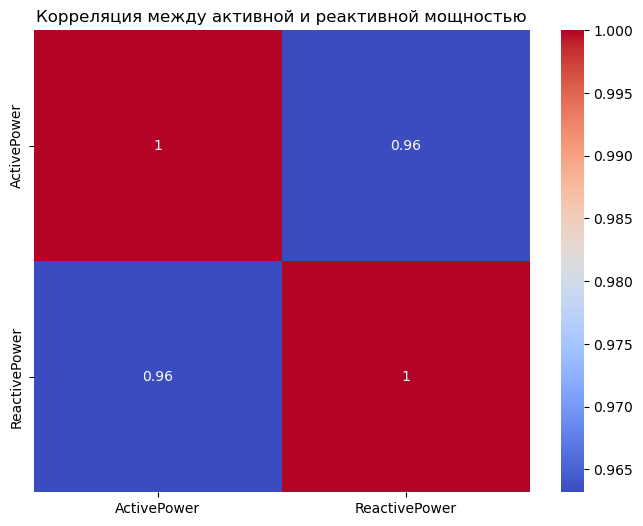

In [21]:
correlation_matrix = data_arc_analysis[['ActivePower', 'ReactivePower']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Корреляция между активной и реактивной мощностью');

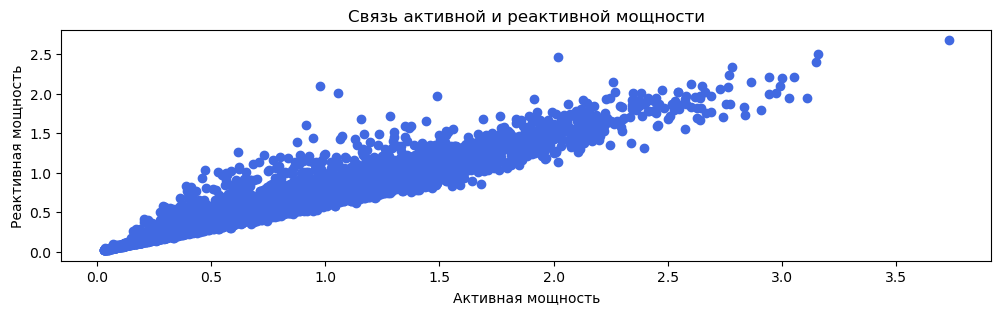

In [22]:
plt.figure(figsize=(12, 3))
plt.scatter(data_arc_analysis['ActivePower'], data_arc_analysis['ReactivePower'], color='royalblue')
plt.title('Связь активной и реактивной мощности')
plt.xlabel('Активная мощность')
plt.ylabel('Реактивная мощность');

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


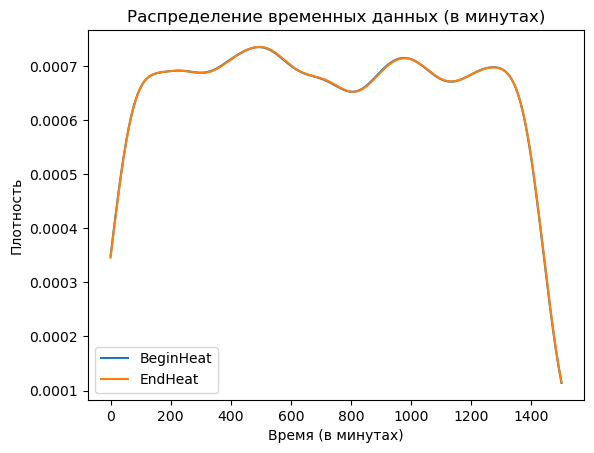

In [23]:
for column in ['BeginHeat', 'EndHeat']:
    sns.kdeplot(data_arc_analysis[column], label=column, clip=(0,1500))
# Настройки графика
plt.title('Распределение временных данных (в минутах)')
plt.xlabel('Время (в минутах)')
plt.ylabel('Плотность')

# Добавление легенды
plt.legend()

# Отображение графика
plt.show();

## Данные об объёме сыпучих материалов

Таблица steel.data_bulk
* key — номер партии;
* Bulk1 … Bulk15 — объём подаваемого материала.

In [24]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [25]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [26]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [27]:
data_bulk['Bulk 1'].value_counts()

Bulk 1
27.0     75
46.0     30
48.0     16
44.0     16
31.0     14
28.0     11
54.0     10
34.0      6
29.0      6
26.0      5
22.0      5
30.0      5
38.0      5
62.0      3
52.0      3
73.0      3
39.0      2
37.0      2
50.0      2
92.0      2
36.0      2
16.0      2
24.0      2
43.0      2
32.0      1
19.0      1
104.0     1
69.0      1
74.0      1
118.0     1
47.0      1
78.0      1
21.0      1
67.0      1
63.0      1
51.0      1
58.0      1
83.0      1
33.0      1
60.0      1
65.0      1
90.0      1
75.0      1
94.0      1
185.0     1
10.0      1
41.0      1
Name: count, dtype: int64

In [28]:
bulk_columns = [col for col in data_bulk.columns if "Bulk " in col]

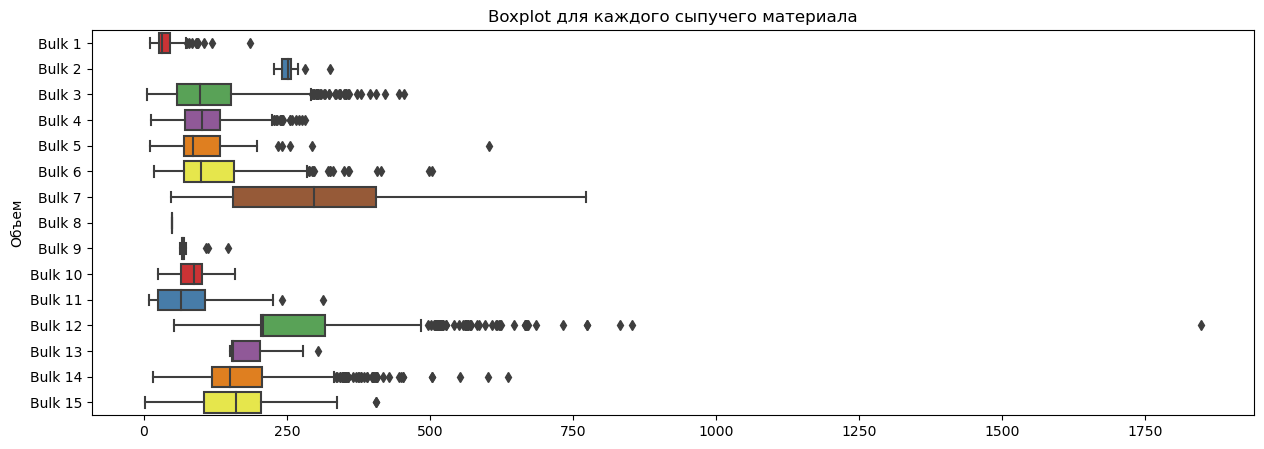

In [29]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=data_bulk[bulk_columns], orient='h', palette='Set1')
plt.title('Boxplot для каждого сыпучего материала')
plt.ylabel('Объем')
plt.show()

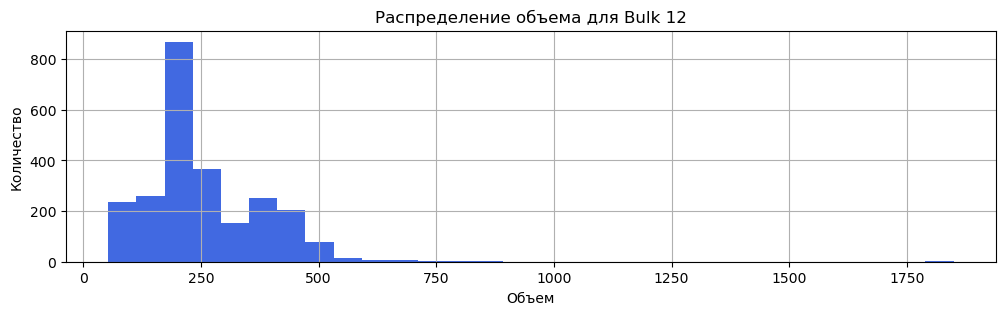

In [30]:
plt.figure(figsize=(12, 3))
data_bulk['Bulk 12'].hist(bins=30, color='royalblue')
plt.title(f'Распределение объема для Bulk 12')
plt.xlabel('Объем')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

In [31]:
data_bulk.fillna(0, inplace=True)

In [32]:
data_bulk.duplicated().sum()

0

## Данные о времени подачи сыпучих материалов

Таблица steel.data_bulk_time
* key — номер партии;
* Bulk1 … Bulk15 — время подачи материала.

In [33]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [34]:
data_bulk_time.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [35]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


In [36]:
data_bulk_time.duplicated().sum()

0

In [37]:
for i in range(1, 16):
    data_bulk_time[f"Bulk {i}"] = pd.to_datetime(data_bulk_time[f"Bulk {i}"], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data_bulk_time[f"Bulk {i}"], format='%H:%M:%S').dt.minute

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

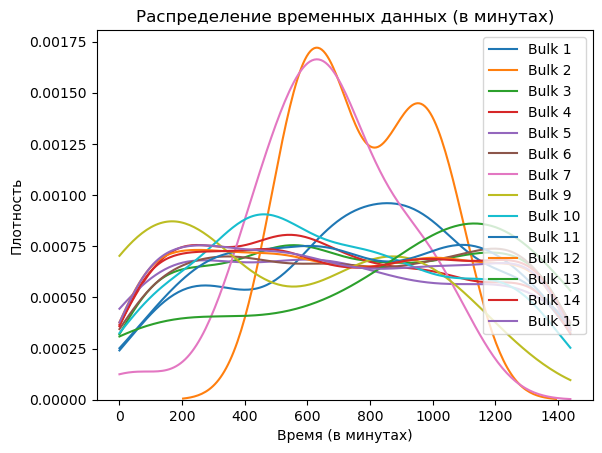

In [38]:
for i in range(1, 16):
    sns.kdeplot(data_bulk_time[data_bulk_time[f'Bulk {i}'] > 0][f'Bulk {i}'], label=f'Bulk {i}', clip=(1, 1439))

plt.title('Распределение временных данных (в минутах)')
plt.xlabel('Время (в минутах)')
plt.ylabel('Плотность')
plt.legend()
plt.show();

In [39]:
data_bulk_time.fillna(0, inplace=True)

In [40]:
data_bulk_time.duplicated().sum()

0

## Данные о продувке сплава газом

Таблица steel.data_gas
* key — номер партии;
* gas — объём подаваемого газа.

In [41]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [42]:
data_gas.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [43]:
data_gas.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [44]:
data_gas.duplicated().sum()

0

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


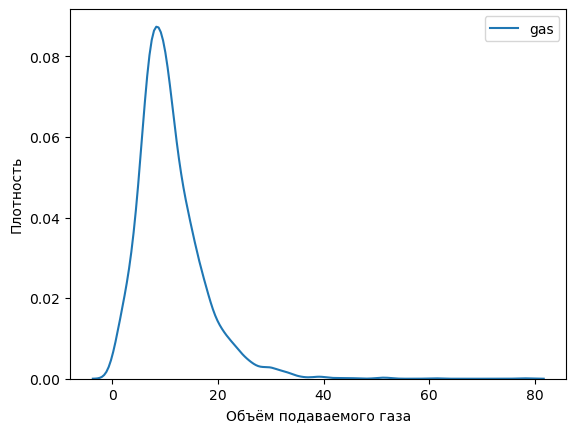

In [45]:
sns.kdeplot(data_gas['gas'], label='gas')

plt.xlabel('Объём подаваемого газа')
plt.ylabel('Плотность')
plt.legend()
plt.show();

## Данные об измерениях температуры

Таблица steel.data_temp
* key — номер партии;
* MesaureTime — время замера;
* Temperature — значение температуры.

In [46]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [47]:
data_temp.describe()

,key,Temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [48]:
data_temp.head()

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


In [49]:
data_temp["MesaureTime"] = pd.to_datetime(data_temp["MesaureTime"], format='%H:%M:%S').dt.time

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


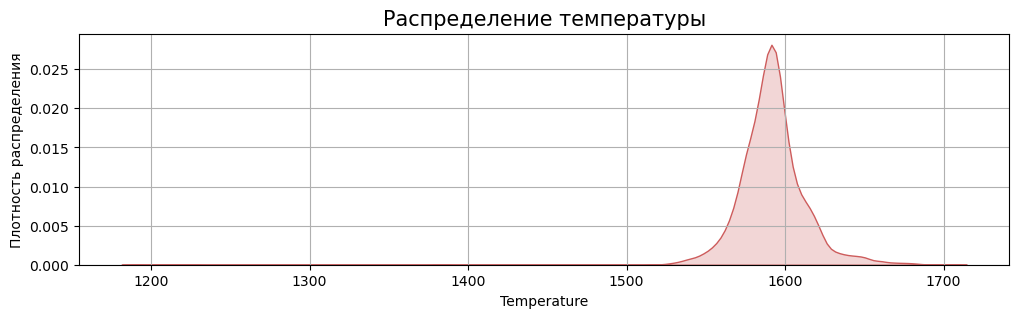

In [50]:
plt.figure(figsize=(12, 3))
sns.kdeplot(data_temp['Temperature'], color='indianred', legend=True, fill=True)
plt.xlabel('Temperature')
plt.ylabel('Плотность распределения')
plt.title('Распределение температуры', fontsize=15)
plt.grid();

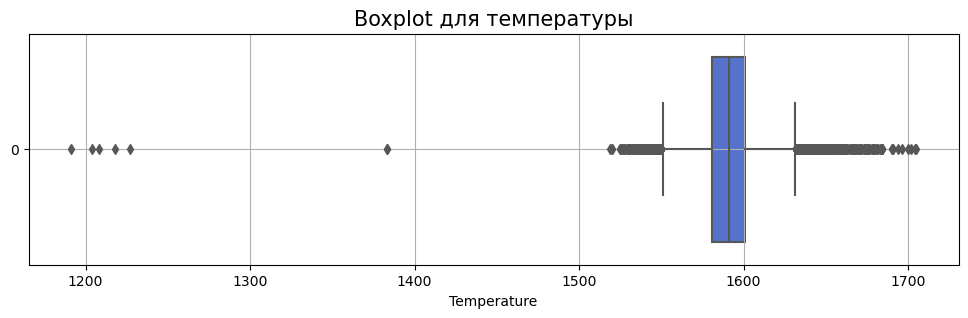

In [51]:
plt.figure(figsize=(12, 3))
sns.boxplot(data=data_temp['Temperature'], orient='h', color='royalblue')
plt.xlabel('Temperature')
plt.title('Boxplot для температуры', fontsize=15)
plt.grid()

In [52]:
data_temp = data_temp.dropna(subset=['Temperature'])

In [53]:
data_temp.duplicated().sum()

0

In [54]:
keys = data_temp['key'].unique()
data_temp_t = pd.DataFrame(columns=['key', 'start', 'temperature_1', 'end', 'temperature_2'])

for key in keys:
    sorted_data = data_temp[data_temp['key']==key].sort_values(by='MesaureTime')
    temp1 = sorted_data.iloc[0]['Temperature']
    temp2 = sorted_data.iloc[-1]['Temperature']
    t1 = sorted_data.iloc[0]['MesaureTime']
    t2 = sorted_data.iloc[-1]['MesaureTime']
    data_temp_t.loc[len(data_temp_t)] = [key, t1, temp1, t2, temp2]

In [55]:
data_temp_t

,key,start,temperature_1,end,temperature_2
0,1,11:16:18,1571.0,11:30:39,1613.0
1,2,11:37:27,1581.0,11:59:12,1602.0
2,3,12:13:17,1596.0,12:34:57,1599.0
3,4,12:52:57,1601.0,12:59:25,1625.0
4,5,13:23:19,1576.0,13:36:01,1602.0
...,...,...,...,...,...
3211,3237,22:44:04,1569.0,22:44:04,1569.0
3212,3238,23:30:31,1584.0,23:30:31,1584.0
3213,3239,01:31:47,1598.0,01:31:47,1598.0
3214,3240,02:39:01,1617.0,02:39:01,1617.0


In [56]:
data_temp = data_temp_t
data_temp.columns = ['key', 'start', 'temperature_1', 'end', 'temperature_2']
data_temp = data_temp.reset_index()
data_temp = data_temp.drop(['index'], axis=1)
data_temp.head()

,key,start,temperature_1,end,temperature_2
0,1,11:16:18,1571.0,11:30:39,1613.0
1,2,11:37:27,1581.0,11:59:12,1602.0
2,3,12:13:17,1596.0,12:34:57,1599.0
3,4,12:52:57,1601.0,12:59:25,1625.0
4,5,13:23:19,1576.0,13:36:01,1602.0


In [57]:
data_temp['start'] = pd.to_datetime(data_temp['start'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data_temp['start'], format='%H:%M:%S').dt.minute
data_temp['end'] = pd.to_datetime(data_temp['end'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data_temp['end'], format='%H:%M:%S').dt.minute

data_temp['process_time'] = data_temp['end'] - data_temp['start']
data_temp = data_temp.drop(columns=['start', 'end'], axis=1)
data_temp.head()

,key,temperature_1,temperature_2,process_time
0,1,1571.0,1613.0,14
1,2,1581.0,1602.0,22
2,3,1596.0,1599.0,21
3,4,1601.0,1625.0,7
4,5,1576.0,1602.0,13


In [58]:
data_temp.shape[0]

3216

In [59]:
data_temp = data_temp.query('temperature_1 > 1500 & temperature_2 > 1500')
data_temp.shape[0]

3211

## Данные об объёме проволочных материалов

Таблица steel.data_wire
* key — номер партии;
* Wire1 … Wire15 — объём подаваемых проволочных материалов.

In [60]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [61]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [62]:
data_wire.sample(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1183,1251,127.249201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1077,1144,159.213608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1790,1880,70.199997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
469,501,23.165998,14.08472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,674,20.170799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
data_wire.duplicated().sum()

0

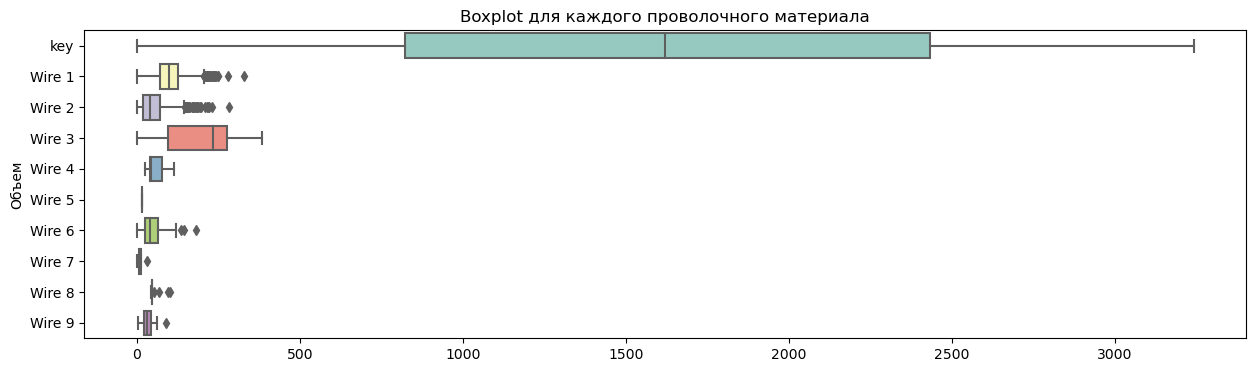

In [64]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=data_wire, orient='h', palette='Set3')
plt.title('Boxplot для каждого проволочного материала')
plt.ylabel('Объем')
plt.show()

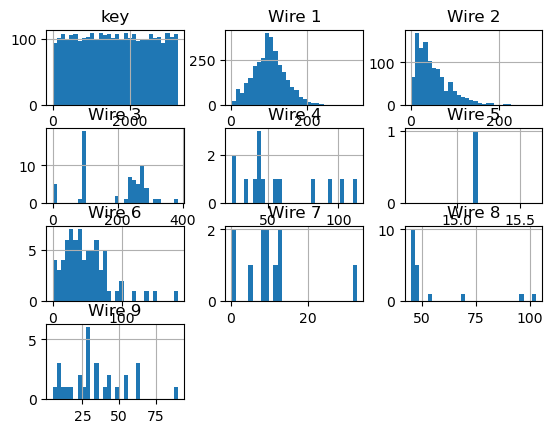

In [65]:
data_wire.hist(bins=30)
plt.xlabel('Объем')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

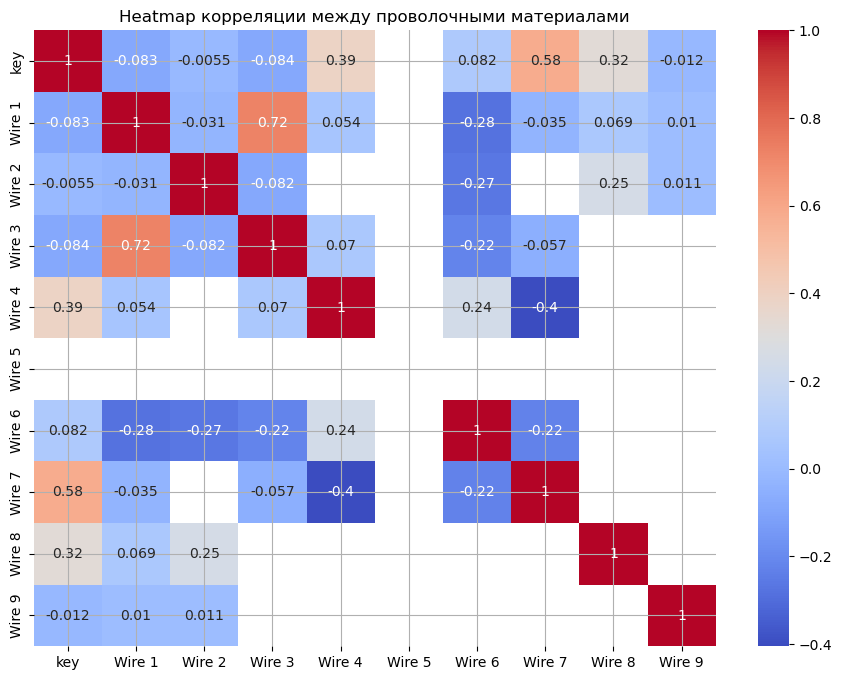

In [66]:
correlation = data_wire.corr()
plt.figure(figsize=(11, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Heatmap корреляции между проволочными материалами')
plt.grid();

In [67]:
data_wire.fillna(0, inplace=True)

## Данные о времени подачи проволочных материалов

Таблица steel.data_wire_time
* key — номер партии;
* Wire1 … Wire15 — время подачи проволочных материалов.

In [68]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [69]:
data_wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [70]:
data_wire_time.sample(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
841,894,08:15:29,None,None,None,None,None,None,None,None
2143,2253,09:14:21,None,None,None,None,None,None,None,None
25,26,07:16:17,None,None,None,None,None,None,None,None
945,1005,06:16:09,None,None,None,None,None,None,None,None
2665,2804,04:43:34,None,None,None,None,None,None,None,None


In [71]:
for i in range(1, 10):
    data_wire_time[f"Wire {i}"] = pd.to_datetime(data_wire_time[f"Wire {i}"], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data_wire_time[f"Wire {i}"], format='%H:%M:%S').dt.minute

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
u

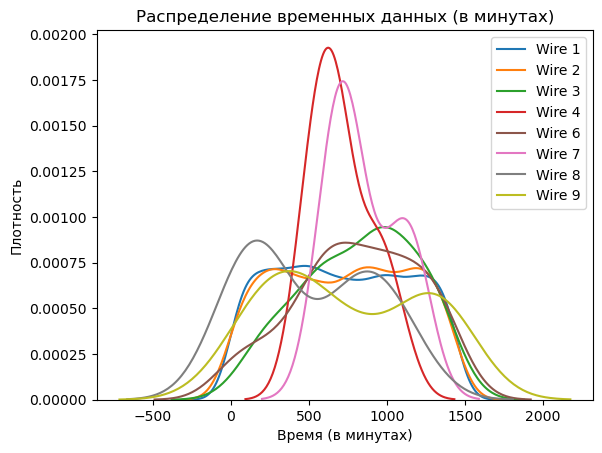

In [72]:
for i in range(1, 10):
    sns.kdeplot(data_wire_time[data_wire_time[f'Wire {i}'] > 0][f'Wire {i}'], label=f'Wire {i}', clip=(None, None))

# Настройки графика
plt.title('Распределение временных данных (в минутах)')
plt.xlabel('Время (в минутах)')
plt.ylabel('Плотность')

# Добавление легенды
plt.legend()

# Отображение графика
plt.show();

In [73]:
data_wire_time.fillna(0, inplace=True)

In [74]:
data_wire_time.duplicated().sum()

0

## Объединение и подготовка данных

In [75]:
df = data_arc.merge(right=data_bulk, how='inner', on='key')\
                  .merge(right=data_gas, how='inner', on='key')\
                  .merge(right=data_temp, how='inner', on='key')\
                  .merge(right=data_wire, how='inner', on='key')

In [76]:
df

,key,ActivePower,ReactivePower,FullPower,delta_t,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,process_time,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,0.975629,0.636648,1.165279,3.600,0.0,0.0,0.0,43.0,0.0,...,14,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.763150,0.499528,0.912304,3.500,0.0,0.0,0.0,73.0,0.0,...,22,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.505176,0.319815,0.597907,2.400,0.0,0.0,0.0,34.0,0.0,...,21,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.802313,0.515074,0.953741,3.000,0.0,0.0,0.0,81.0,0.0,...,7,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.836793,0.563161,1.008939,3.500,0.0,0.0,0.0,78.0,0.0,...,13,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3012,3237,0.786493,0.565692,0.968996,3.000,0.0,0.0,170.0,0.0,0.0,...,0,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3013,3238,0.702176,0.560394,0.898847,3.000,0.0,0.0,126.0,0.0,0.0,...,0,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3014,3239,0.583344,0.388952,0.701485,2.625,0.0,0.0,0.0,0.0,0.0,...,0,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3015,3240,0.596817,0.496653,0.778371,3.200,0.0,0.0,0.0,0.0,0.0,...,0,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
df = df.drop(df.query('key == 2116').index).reset_index(drop=True)
df = df[df['Bulk 12'] < 1750]

In [78]:
df.duplicated().sum()

0

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3015 entries, 0 to 3015
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            3015 non-null   int64  
 1   ActivePower    3015 non-null   float64
 2   ReactivePower  3015 non-null   float64
 3   FullPower      3015 non-null   float64
 4   delta_t        3015 non-null   float64
 5   Bulk 1         3015 non-null   float64
 6   Bulk 2         3015 non-null   float64
 7   Bulk 3         3015 non-null   float64
 8   Bulk 4         3015 non-null   float64
 9   Bulk 5         3015 non-null   float64
 10  Bulk 6         3015 non-null   float64
 11  Bulk 7         3015 non-null   float64
 12  Bulk 8         3015 non-null   float64
 13  Bulk 9         3015 non-null   float64
 14  Bulk 10        3015 non-null   float64
 15  Bulk 11        3015 non-null   float64
 16  Bulk 12        3015 non-null   float64
 17  Bulk 13        3015 non-null   float64
 18  Bulk 14      

Text(0.5, 1.0, 'Heatmap корреляции между признаками')

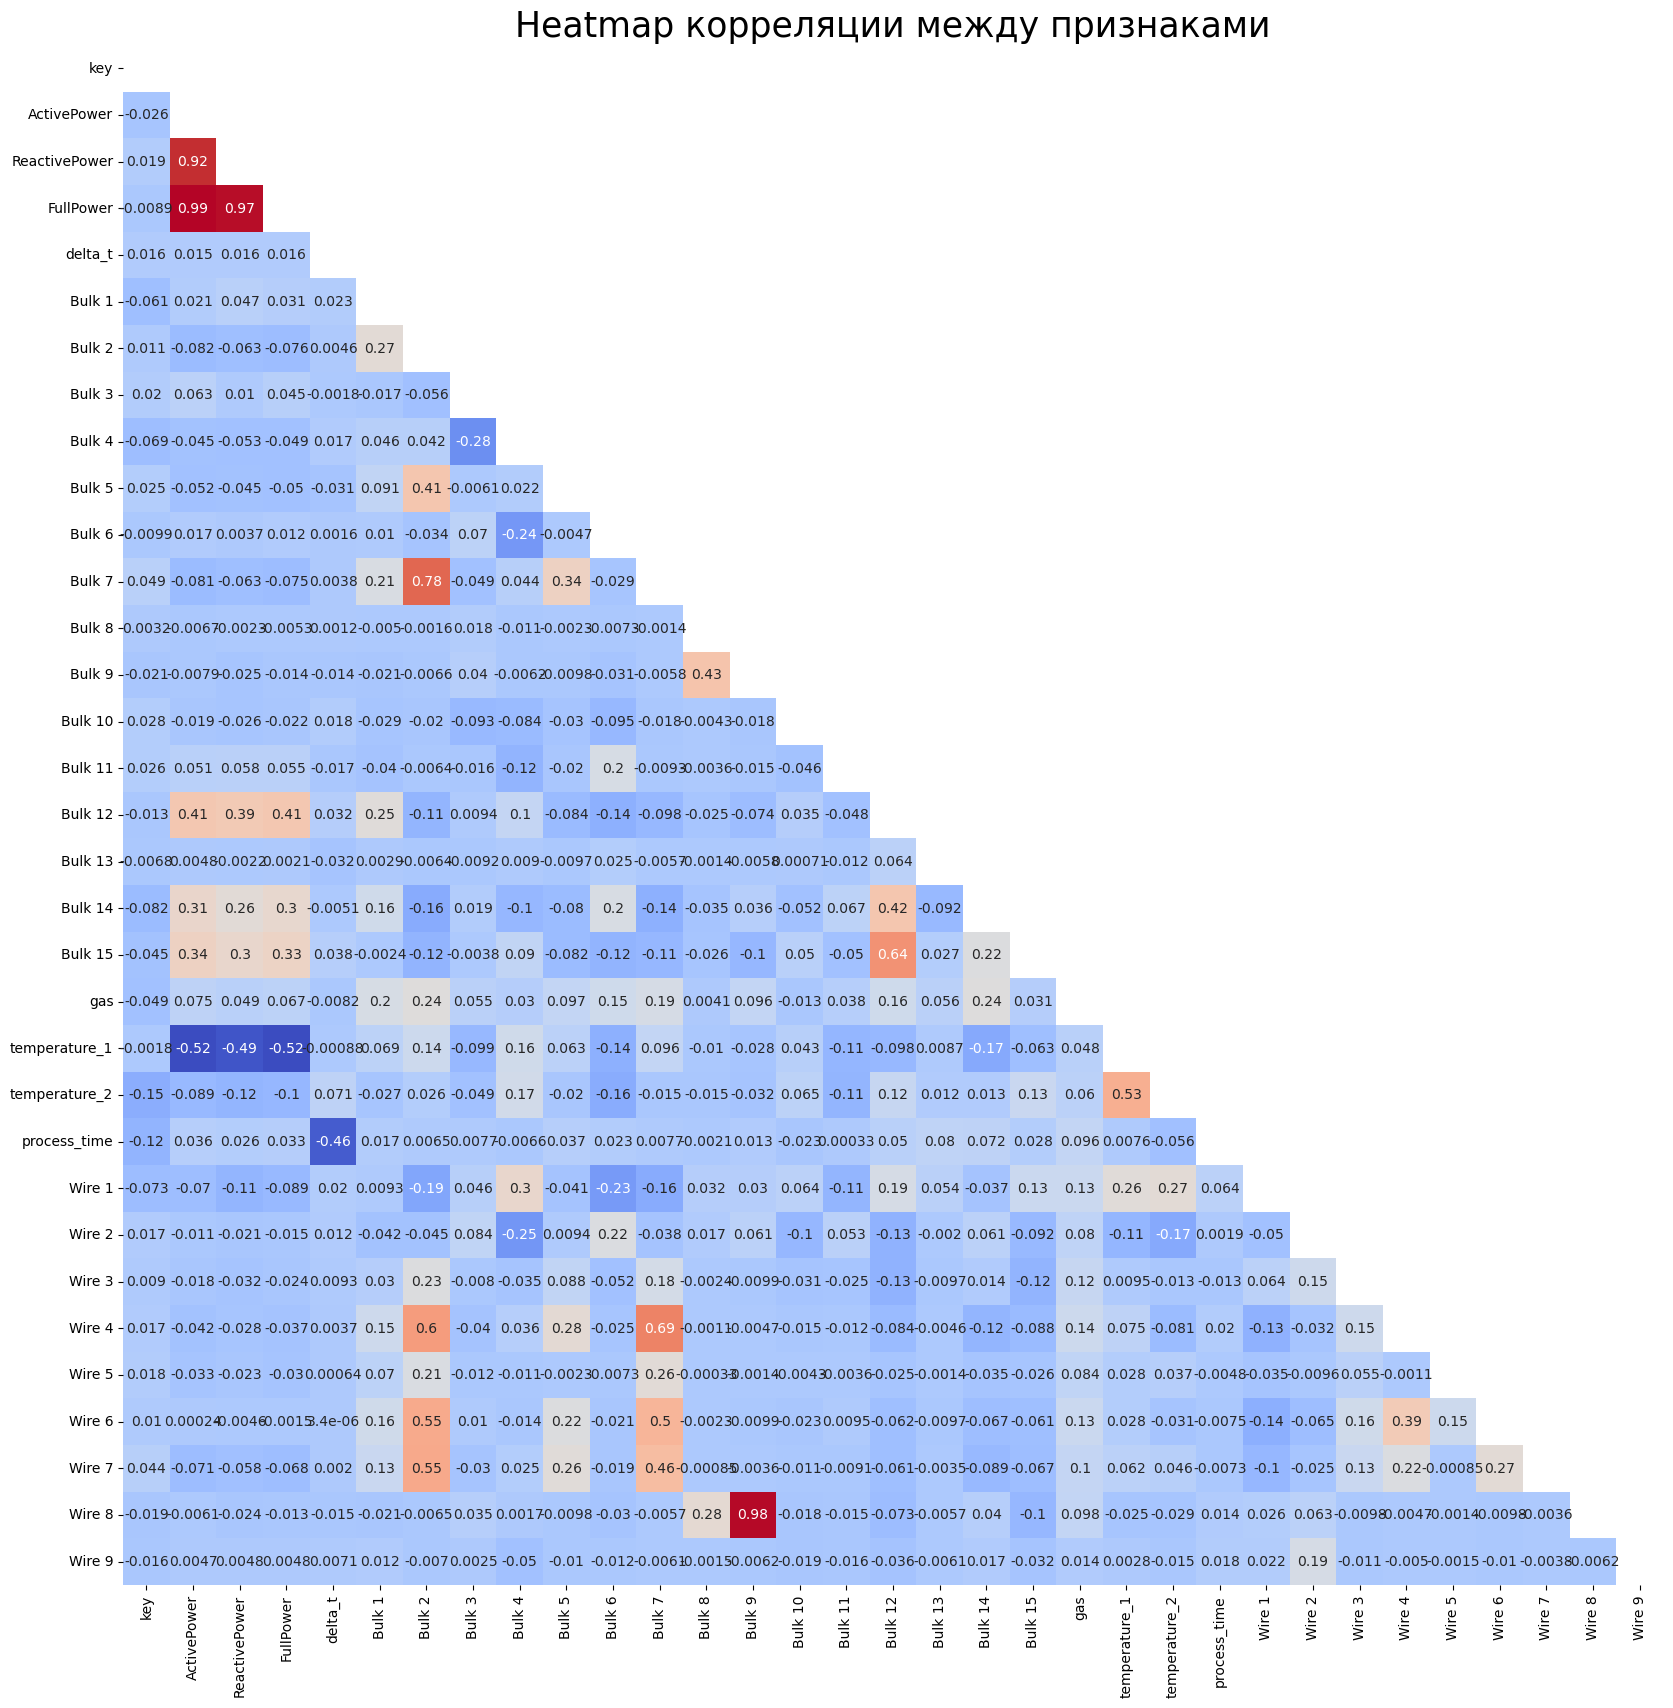

In [80]:
plt.figure(figsize=(20, 20))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(),
            annot=True,
            mask=matrix,
            square=True,
            cmap='coolwarm',
            cbar=False)
plt.title('Heatmap корреляции между признаками', fontsize=25)

# Подготовка данных к обучению

In [81]:
features = df.drop(['temperature_2', 'key'], axis=1)
target = df['temperature_2']

In [82]:
features.shape, target.shape

((3015, 31), (3015,))

In [83]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=.25,
                                                                            random_state=RANDOM_STATE)

In [84]:
print(f'Train: {features_train.shape, target_train.shape}')
print(f'Test: {features_test.shape, target_test.shape}')

Train: ((2261, 31), (2261,))
Test: ((754, 31), (754,))


In [85]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train), columns=features_train.columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)

In [86]:
display(features_train.head(), features_test.head())

,ActivePower,ReactivePower,FullPower,delta_t,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,process_time,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,-0.372338,-0.181251,-0.313323,0.071109,-0.280788,-0.089267,0.480001,-0.599749,-0.127544,-0.398446,...,-0.184008,-1.080627,1.407455,-0.129587,-0.066355,-0.021035,-0.135572,-0.04661,-0.080441,-0.085078
1,-1.390321,-1.505361,-1.457735,0.045519,-0.280788,-0.089267,1.218142,-0.599749,-0.127544,-0.398446,...,-0.125156,1.424924,0.363347,-0.129587,-0.066355,-0.021035,-0.135572,-0.04661,-0.080441,-0.085078
2,-0.817523,-1.062215,-0.921783,0.045519,-0.280788,-0.089267,-0.660763,-0.599749,0.851213,2.965247,...,-0.151907,0.478162,1.654343,-0.129587,-0.066355,-0.021035,-0.135572,-0.04661,-0.080441,-0.085078
3,2.531098,2.037938,2.386048,0.139349,-0.280788,-0.089267,1.983125,-0.599749,-0.127544,-0.398446,...,-0.098405,0.123540,0.375018,9.328672,-0.066355,-0.021035,-0.135572,-0.04661,-0.080441,-0.085078
4,-1.221492,-1.157570,-1.219840,0.067697,-0.280788,-0.089267,-0.660763,-0.599749,-0.127544,2.611174,...,-0.055603,-0.555876,-0.529936,-0.129587,-0.066355,-0.021035,-0.135572,-0.04661,-0.080441,-0.085078


,ActivePower,ReactivePower,FullPower,delta_t,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,process_time,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,2.232252,1.960877,2.160289,0.130819,-0.280788,-0.089267,-0.660763,-0.599749,-0.127544,-0.398446,...,-0.264261,-1.075988,-0.260604,-0.129587,-0.066355,-0.021035,-0.135572,-0.04661,-0.080441,-0.085078
1,-0.587603,-0.040802,-0.390973,0.071109,-0.280788,-0.089267,-0.660763,0.042160,-0.127544,-0.398446,...,-0.162607,-0.702806,-0.530834,-0.129587,-0.066355,-0.021035,-0.135572,-0.04661,-0.080441,-0.085078
2,-0.874952,-0.370528,-0.695914,0.071109,-0.280788,-0.089267,-0.660763,2.877257,-0.127544,-0.398446,...,-0.162607,0.241747,-0.530834,-0.129587,-0.066355,-0.021035,-0.135572,-0.04661,-0.080441,-0.085078
3,2.010393,2.398582,2.178635,0.145036,-0.280788,-0.089267,-0.660763,-0.599749,-0.127544,1.247994,...,-0.071654,-2.049338,-0.530834,-0.129587,-0.066355,-0.021035,-0.135572,-0.04661,-0.080441,-0.085078
4,-1.020966,-0.997419,-1.031085,0.054049,2.096315,-0.089267,-0.660763,0.862377,-0.127544,-0.398446,...,-0.167957,0.077141,-0.530834,-0.129587,-0.066355,-0.021035,-0.135572,-0.04661,-0.080441,-0.085078


# Обучение модели

In [87]:
dummy_clf = DummyRegressor()
dummy_clf.fit(features_train, target_train)
predicted = dummy_clf.predict(features_test)
print(f'MAE дамми предиктора: {mae(target_test, predicted)}')

MAE дамми предиктора: 11.03511567966569


In [88]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)
param_dist_rf = {'n_estimators': [50, 100, 200],
                 'max_depth': [None, 10, 20, 30, 50],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4],
                 'max_features': ['auto', 'sqrt', 'log2']}
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, cv=5, scoring='neg_mean_absolute_error', n_iter=10)
random_search_rf.fit(features_train, target_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=190224),
                   param_distributions={'max_depth': [None, 10, 20, 30, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   scoring='neg_mean_absolute_error')

In [89]:
catboost = CatBoostRegressor(random_seed=RANDOM_STATE)
param_dist_catboost = {'iterations': [50, 100, 200],
                       'learning_rate': [0.01, 0.05, 0.1],
                       'depth': [4, 6, 8]}
random_search_catboost = RandomizedSearchCV(catboost, param_distributions=param_dist_catboost, cv=5, scoring='neg_mean_absolute_error', n_iter=10)
random_search_catboost.fit(features_train, target_train)

0:	learn: 14.2573116	total: 55.7ms	remaining: 11.1s
1:	learn: 13.6209002	total: 56.8ms	remaining: 5.62s
2:	learn: 13.0536931	total: 57.8ms	remaining: 3.79s
3:	learn: 12.5780965	total: 58.7ms	remaining: 2.87s
4:	learn: 12.1259782	total: 59.5ms	remaining: 2.32s
5:	learn: 11.7273186	total: 60.3ms	remaining: 1.95s
6:	learn: 11.3968985	total: 61.4ms	remaining: 1.69s
7:	learn: 11.0808409	total: 62.4ms	remaining: 1.5s
8:	learn: 10.7779062	total: 64.3ms	remaining: 1.36s
9:	learn: 10.5181743	total: 66.3ms	remaining: 1.26s
10:	learn: 10.2761440	total: 68.8ms	remaining: 1.18s
11:	learn: 10.0428833	total: 70.1ms	remaining: 1.1s
12:	learn: 9.8599833	total: 71.7ms	remaining: 1.03s
13:	learn: 9.6562281	total: 73.6ms	remaining: 977ms
14:	learn: 9.5049023	total: 75.2ms	remaining: 928ms
15:	learn: 9.3770705	total: 77.7ms	remaining: 893ms
16:	learn: 9.2266052	total: 79.8ms	remaining: 859ms
17:	learn: 9.1002050	total: 81.8ms	remaining: 827ms
18:	learn: 8.9823715	total: 84.5ms	remaining: 805ms
19:	learn: 8

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x2985b4490>,
                   param_distributions={'depth': [4, 6, 8],
                                        'iterations': [50, 100, 200],
                                        'learning_rate': [0.01, 0.05, 0.1]},
                   scoring='neg_mean_absolute_error')

In [90]:
linear_reg = LinearRegression()
param_dist_linear = {'fit_intercept': [True, False]}
random_search_linear = RandomizedSearchCV(linear_reg, param_distributions=param_dist_linear, cv=5, scoring='neg_mean_absolute_error', n_iter=5)
random_search_linear.fit(features_train, target_train)

The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.


RandomizedSearchCV(cv=5, estimator=LinearRegression(), n_iter=5,
                   param_distributions={'fit_intercept': [True, False]},
                   scoring='neg_mean_absolute_error')

In [91]:
mlp = MLPRegressor(random_state=RANDOM_STATE)
param_dist_mlp = {'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
                  'activation': ['relu', 'tanh'],
                  'alpha': [0.0001, 0.001, 0.01],
                  'learning_rate': ['constant', 'invscaling', 'adaptive']}
random_search_mlp = RandomizedSearchCV(mlp, param_distributions=param_dist_mlp, cv=5, scoring='neg_mean_absolute_error', n_iter=10)
random_search_mlp.fit(features_train, target_train)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

RandomizedSearchCV(cv=5, estimator=MLPRegressor(random_state=190224),
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'alpha': [0.0001, 0.001, 0.01],
                                        'hidden_layer_sizes': [(50,), (100,),
                                                               (50, 50),
                                                               (100, 100)],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive']},
                   scoring='neg_mean_absolute_error')

In [92]:
rf_mae = -random_search_rf.best_score_
catboost_mae = -random_search_catboost.best_score_
linear_mae = -random_search_linear.best_score_
mlp_mae = -random_search_mlp.best_score_

In [93]:
mae_values = {'Random Forest': rf_mae, 'CatBoost': catboost_mae, 'Linear Regression': linear_mae, 'MLP': mlp_mae}
best_model = min(mae_values, key=mae_values.get)
best_mae = mae_values[best_model]

In [94]:
print("Лучшая модель:", best_model)
print("MAE на кросс-валидации:", best_mae)

Лучшая модель: CatBoost
MAE на кросс-валидации: 5.651497916496689


In [95]:
results_df = pd.DataFrame(columns=['Модель', 'Параметры', 'MAE на кросс-валидации'])

results_df.loc[0] = ['Random Forest', random_search_rf.best_params_, rf_mae]
results_df.loc[1] = ['CatBoost', random_search_catboost.best_params_, catboost_mae]
results_df.loc[2] = ['Linear Regression', random_search_linear.best_params_, linear_mae]
results_df.loc[3] = ['MLP', random_search_mlp.best_params_, mlp_mae]

results_df

,Модель,Параметры,MAE на кросс-валидации
0,Random Forest,"{'n_estimators': 200, 'min_samples_split': 2, ...",7.152774
1,CatBoost,"{'learning_rate': 0.1, 'iterations': 200, 'dep...",5.651498
2,Linear Regression,{'fit_intercept': True},9.154845
3,MLP,"{'learning_rate': 'constant', 'hidden_layer_si...",79.021129


# Тестирование модели

In [96]:
best_params_catboost = results_df[results_df['Модель'] == 'CatBoost']['Параметры'].iloc[0]

best_catboost_model = CatBoostRegressor(verbose=False, **best_params_catboost, random_state=RANDOM_STATE)
best_catboost_model.fit(features_train, target_train)

predictions_test = best_catboost_model.predict(features_test)

mae_test = mae(target_test, predictions_test)
print(f"MAE на тестовой выборке: {mae_test:.2f}")

MAE на тестовой выборке: 5.33


The figure layout has changed to tight


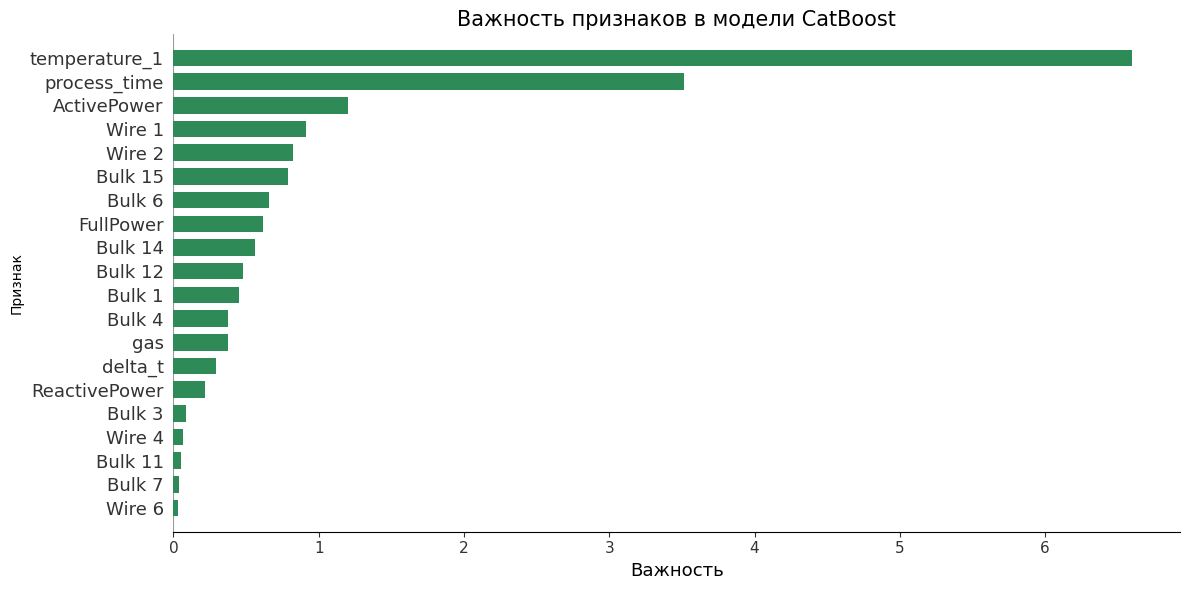

In [97]:
fig, ax = plt.subplots(figsize=(12, 6)) 

explainer = shap.TreeExplainer(best_catboost_model)

shap_values = explainer.shap_values(features_train)

shap.summary_plot(shap_values, features_train, plot_type="bar", color='seagreen', show=False, plot_size=None)
plt.title('Важность признаков в модели CatBoost', fontsize=15)
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()